In [1]:
import pathlib
from itertools import product
from typing import Any, Iterable, Iterator, Tuple

import numpy as np
import xarray as xr

from qec_util import Layout
from surface_sim import Setup
from surface_sim.experiments.rep_code import memory_experiment
from surface_sim.models import ExperimentalNoiseModel
from surface_sim.util import sample_experiment

In [2]:
def param_product(*params: Any) -> Iterator[Tuple[Any, ...]]:
    par_iters = [par if isinstance(par, Iterable) else (par,) for par in params]
    yield from product(*par_iters)

In [3]:
EXP_DIR = pathlib.Path.cwd()
CONFIG_DIR = EXP_DIR / "config"

In [4]:
SETUP_FILE = "exp_noise.yaml"
LAYOUT_FILE = f"rep_code_chain_layout.yaml"

layout = Layout.from_yaml(CONFIG_DIR / LAYOUT_FILE)
setup = Setup.from_yaml(CONFIG_DIR / SETUP_FILE)

model = ExperimentalNoiseModel(setup, layout)

In [5]:
DATASET_TYPE = "data"
ROOT_SEED = np.random.randint(999999)  # Initial seed for the RNG

# Variable parameters
# NUM_ROUNDS = list(range(1, 41, 4))  # Train and dev dataset
NUM_ROUNDS = list(range(0, 16)) # Test dataset

NUM_SHOTS: int = 250000

DATA_INITS = [[0, 1, 0, 1, 0, 1, 0], [1, 0, 1, 0, 1, 0, 1]]  # Logical state(s)
# %%
params = tuple(param_product(DATA_INITS, NUM_ROUNDS))
num_runs = len(params)

seed_sequence = np.random.SeedSequence(ROOT_SEED)
seeds = iter(seed_sequence.generate_state(num_runs, dtype="uint64"))

data_qubits = layout.get_qubits(role="data")
num_data = len(data_qubits)
distance = layout.distance

anc_qubits = layout.get_qubits(role="anc")
num_anc = len(anc_qubits)

correction_arr = np.zeros(num_anc, dtype=int)
par_corrections = xr.DataArray(
    data = correction_arr,
    dims = ['anc_qubit'],
    coords=dict(anc_qubit=anc_qubits)
)

In [12]:
experiment = memory_experiment(
    model,
    data_init=[0,1,0,1,0,1,0],
    num_rounds=3,
)

In [13]:
experiment

stim.Circuit('''
    R 3 0 4 10 1 11 9 8 6 7 5 2 12
    X_ERROR(0) 3 0 4 10 1 11 9 8 6 7 5 2 12
    TICK
    X 2 10 6
    DEPOLARIZE1(0.0048) 2
    DEPOLARIZE1(0.0122) 10
    DEPOLARIZE1(0.0022) 6
    PAULI_CHANNEL_1(0.000572934, 0.000572934, 0.00029716) 3
    PAULI_CHANNEL_1(0.000275164, 0.000275164, 0.000418943) 0
    PAULI_CHANNEL_1(0.000434103, 0.000434103, 0.000501) 4
    PAULI_CHANNEL_1(0.000707413, 0.000707413, 0.000190656) 1
    PAULI_CHANNEL_1(0.000470721, 0.000470721, 8.3357e-05) 11
    PAULI_CHANNEL_1(0.000402155, 0.000402155, 0.000343001) 9
    PAULI_CHANNEL_1(0.000345542, 0.000345542, 0.000473659) 8
    PAULI_CHANNEL_1(0.000504439, 0.000504439, 0.0010114) 7
    PAULI_CHANNEL_1(0.000852078, 0.000852078, 0.000173878) 12
    PAULI_CHANNEL_1(0.000977516, 0.000977516, 0.00125413) 5
    TICK
    REPEAT 2 {
        H 1 5 9
        DEPOLARIZE1(0.0066) 1
        DEPOLARIZE1(0.0186) 5
        DEPOLARIZE1(0.01) 9
        PAULI_CHANNEL_1(0.000572934, 0.000572934, 0.00029716) 3
       

In [32]:
from stim import Circuit, target_rec

circuit = Circuit()
comp_rounds = 1

num_data = len(data_qubits)
num_anc = len(anc_qubits)

for anc_qubit in anc_qubits:
    nbr_qubits = model.layout.get_neighbors(anc_qubit)
    nbr_inds = (data_qubits.index(nbr_qubit) for nbr_qubit in nbr_qubits)

    targets = [target_rec(ind - num_data) for ind in nbr_inds]

    if comp_rounds:
        anc_ind = anc_qubits.index(anc_qubit)

        for round_ind in range(1, comp_rounds + 1):
            target = target_rec(anc_ind - num_data - round_ind * num_anc)
            targets.append(target)
    circuit.append("DETECTOR", targets)

targets = [target_rec(ind) for ind in range(-num_data, 0)]
circuit.append("OBSERVABLE_INCLUDE", targets, 0)

In [54]:
circuit = Circuit()
comp_rounds =  2
num_anc = len(anc_qubits)

if comp_rounds:
    round_offsets = (1, comp_rounds + 1)
    for ind in range(num_anc):
        targets = [target_rec(ind - num_anc * offset) for offset in round_offsets]
        circuit.append("DETECTOR", targets)
else:
    for anc_ind in range(num_anc):
        target = target_rec(anc_ind - num_anc)
        circuit.append("DETECTOR", target)

In [56]:
not 0

True

In [6]:
from matplotlib import pyplot as plt

from typing import Optional, Tuple

from xarray import DataArray, Dataset


def get_syndromes(anc_meas: DataArray) -> DataArray:
    """
    get_syndromes Calculates the syndrome from the ancilla measurements.

    Parameters
    ----------
    anc_meas : DataArray
        The ancilla measurements, with dimensions 'anc_qubit' and 'qec_round'.

    Returns
    -------
    DataArray
        The calculated syndromes
    """
    syndromes = anc_meas ^ anc_meas.shift(qec_round=1, fill_value=0)
    return syndromes


def get_defects(syndromes: DataArray, frame: Optional[DataArray] = None) -> DataArray:
    """
    get_defects Calculates the defects/detectors from the syndromes

    Parameters
    ----------
    syndromes : DataArray
        The syndromes, either directly measured or calculated
        from the measurements (when ancilla reset is not used).
        Must include dimensions 'anc_qubit' and 'qec_round'.
    frame : Optional[DataArray], optional
        The Pauli frame, by default None

    Returns
    -------
    DataArray
        The calculated defects/detectors
    """
    syndromes = syndromes.transpose(..., "anc_qubit", "qec_round")
    shifted_syndromes = syndromes.shift(qec_round=1, fill_value=0)

    if frame is not None:
        shifted_syndromes[..., 0] = frame

    defects = syndromes ^ shifted_syndromes
    return defects


def get_final_defects(syndromes: DataArray, proj_syndrome: DataArray) -> DataArray:
    """
    get_final_defects Calculates the final defects/detectors from the syndromes
    and the syndromes projected from tthe data-qubt measurements.

    Parameters
    ----------
    syndromes : DataArray
        The syndromes, either directly measured or calculated
        from the measurements (when ancilla reset is not used).
    proj_syndrome : DataArray
        The syndromes projected from the data-qubit measurements.

    Returns
    -------
    DataArray
        The calculated final defects/detectors
    """
    last_round = syndromes.qec_round.values[-1]
    anc_qubits = proj_syndrome.anc_qubit.values

    last_syndromes = syndromes.sel(anc_qubit=anc_qubits, qec_round=last_round)
    defects = last_syndromes ^ proj_syndrome
    return defects


def extract_defects(
    dataset: Dataset, parity_mat: DataArray
) -> Tuple[DataArray, DataArray]:
    corrections = dataset.par_corrections

    syndromes = get_syndromes(dataset.anc_meas)

    frame = dataset.init_state.dot(parity_mat) % 2
    frame = frame ^ corrections

    defects = get_defects(syndromes, frame)

    proj_syndromes = dataset.data_meas.dot(parity_mat) % 2
    proj_syndromes["qec_round"] = dataset.qec_round.size + 1
    proj_syndromes = proj_syndromes ^ corrections

    final_defects = get_final_defects(syndromes, proj_syndromes)
    return defects, final_defects


In [7]:
anc_qubits = layout.get_qubits(role="anc")
anc_qubits.sort(key=lambda qubit: layout.param("chain_ind", qubit))

parity_mat = layout.projection_matrix(stab_type="z_type")
parity_mat = parity_mat.sel(anc_qubit=anc_qubits)

meas_defects, final_defects = extract_defects(dataset, parity_mat)

num_rounds = meas_defects.qec_round.size
final_defects = final_defects.assign_coords(qec_round=num_rounds + 1)

defects = xr.concat([meas_defects, final_defects], dim="qec_round")

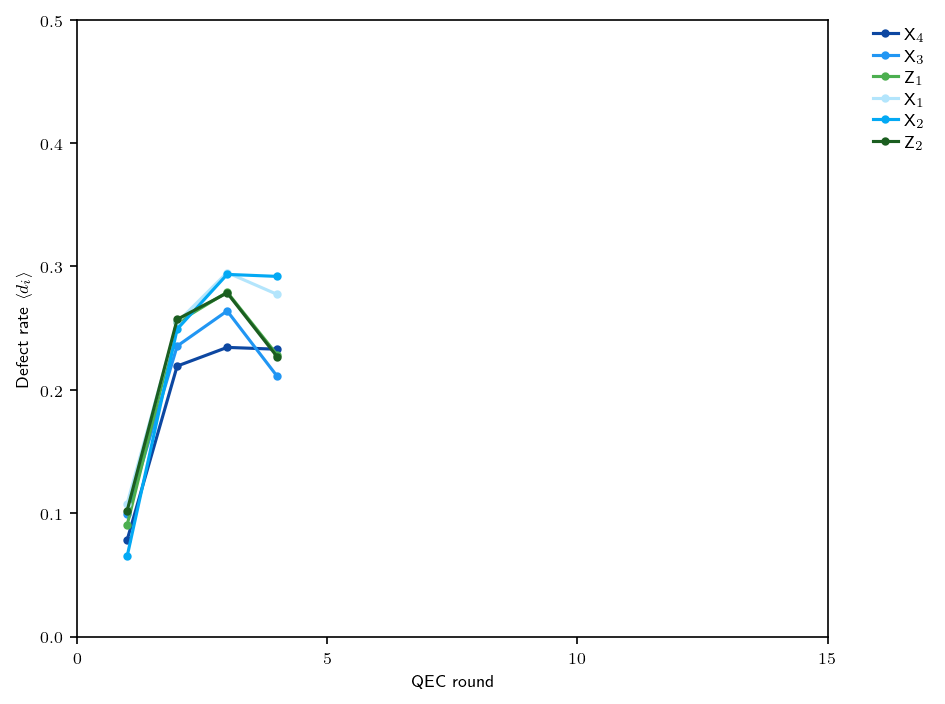

In [8]:
RC_PARAMS = {
    'axes.labelsize': 8,
    'legend.fontsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'font.family': 'serif'
}

PLOT_COLORS = dict(
    X1='#b3e5fc', 
    X2='#03a9f4', 
    X3='#2196f3', 
    X4='#0d47a1', 
    Z1='#4caf50', 
    Z2='#1b5e20'
)
with plt.rc_context(RC_PARAMS):
    fig, ax = plt.subplots(1, 1, dpi=150)

    for anc_qubit in defects.anc_qubit.values:
        plot_label = f"{anc_qubit[0]}$_{{{anc_qubit[1:]}}}$"
        ax.errorbar(
            defects.qec_round,
            defects.sel(anc_qubit=anc_qubit).mean(dim='shot'), 
            color=PLOT_COLORS[anc_qubit],
            label=plot_label,
            marker='.'
        )

    ax.set_ylabel(r'Defect rate $\left\langle d_{i} \right\rangle$')
    ax.set_ylim(0, 0.5)
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    ax.set_xlabel('QEC round')
    ax.set_xticks([0, 5, 10, 15])
    
    ax.legend(
        frameon=False, 
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        handletextpad=0.4,
        labelspacing=0.4,
        markerscale=1.0,
        handlelength=1.5,
        borderaxespad=0.05,
        columnspacing=0.4
    )

plt.tight_layout()
plt.show()

In [9]:
for inst in error_model:
    print(inst)

error(0.00818891) D0 D1 L0
error(0.0520505) D0 D6
error(0.0125707) D0 L0
error(0.0125846) D1 D2 L0
error(0.016008) D1 D6 L0
error(0.0491454) D1 D7
error(0.0220315) D1 D8 L0
error(0.011095) D2 D3 L0
error(0.0706009) D2 D8
error(0.0120012) D3 D4 L0
error(0.0194247) D3 D8 L0
error(0.056123) D3 D9
error(0.0175588) D3 D10 L0
error(0.00703826) D4 D5 L0
error(0.0463288) D4 D10
error(0.0142546) D5 D10 L0
error(0.0526304) D5 D11
error(0.0235287) D5 L0
error(0.0493783) D6 D7 L0
error(0.0821358) D6 D12
error(0.0506596) D6 L0
error(0.0104197) D6 L0 ^ D0 L0
error(0.0587788) D7 D8 L0
error(0.016008) D7 D12 L0
error(0.102428) D7 D13
error(0.0220315) D7 D14 L0
error(0.0453658) D8 D9 L0
error(0.11487) D8 D14
error(0.0484304) D9 D10 L0
error(0.0194247) D9 D14 L0
error(0.135819) D9 D15
error(0.0175588) D9 D16 L0
error(0.0551209) D10 D11 L0
error(0.128663) D10 D16
error(0.0142546) D11 D16 L0
error(0.08612) D11 D17
error(0.0997123) D11 L0
error(0.01202) D11 L0 ^ D5 L0
error(0.0493783) D12 D13 L0
error(0.08

In [10]:
from pymatching import Matching

In [19]:
graph = Matching.from_detector_error_model(error_model)

In [44]:
for start_node, end_node, attrs in graph.edges():
    fault_ids = attrs["fault_ids"]
    num_faults = len(fault_ids)
    assert num_faults <= 1

    prob = attrs["error_probability"]

    end_node_label = end_node or "B"
    print(f"E({start_node}, {end_node_label}) with p={prob:.6f} ->  {num_faults}")

E(0, 1) with p=0.008189 ->  1
E(0, 6) with p=0.052050 ->  0
E(0, B) with p=0.022728 ->  1
E(1, 2) with p=0.012585 ->  1
E(1, 6) with p=0.016008 ->  1
E(1, 7) with p=0.049145 ->  0
E(1, 8) with p=0.022031 ->  1
E(2, 3) with p=0.011095 ->  1
E(2, 8) with p=0.070601 ->  0
E(3, 4) with p=0.012001 ->  1
E(3, 8) with p=0.019425 ->  1
E(3, 9) with p=0.056123 ->  0
E(3, 10) with p=0.017559 ->  1
E(4, 5) with p=0.007038 ->  1
E(4, 10) with p=0.046329 ->  0
E(5, 10) with p=0.014255 ->  1
E(5, 11) with p=0.052630 ->  0
E(5, B) with p=0.034983 ->  1
E(6, 7) with p=0.049378 ->  1
E(6, 12) with p=0.082136 ->  0
E(6, B) with p=0.069192 ->  1
E(7, 8) with p=0.058779 ->  1
E(7, 12) with p=0.016008 ->  1
E(7, 13) with p=0.102428 ->  0
E(7, 14) with p=0.022031 ->  1
E(8, 9) with p=0.045366 ->  1
E(8, 14) with p=0.114870 ->  0
E(9, 10) with p=0.048430 ->  1
E(9, 14) with p=0.019425 ->  1
E(9, 15) with p=0.135819 ->  0
E(9, 16) with p=0.017559 ->  1
E(10, 11) with p=0.055121 ->  1
E(10, 16) with p=0.128663

In [35]:
anc_qubits = list(defects.anc_qubit.values)
qec_rounds = list(defects.qec_round.values)

indexer = NodeIndexer(anc_qubits, qec_rounds)

included_qubits = ["X4", "X3"]

In [38]:
subgraph = Matching()

for start_node, end_node, attrs in graph.edges():
    start_anc, start_round = indexer.coordinates(start_node)

    if start_anc not in included_qubits:
        continue

    if end_node is None:
        subgraph.add_boundary_edge(start_node, **attrs, merge_strategy="independent")
    else:
        end_anc, end_round = indexer.coordinates(end_node)
        if end_anc in included_qubits:
            subgraph.add_edge(start_node, end_node, **attrs, merge_strategy="independent")
        else:
            subgraph.add_boundary_edge(start_node, **attrs, merge_strategy="independent")
        

In [43]:
for start_node, end_node, attrs in subgraph.edges():
    fault_ids = attrs["fault_ids"]
    num_faults = len(fault_ids)
    assert num_faults <= 1

    prob = attrs["error_probability"]

    end_node_label = end_node or "B"
    print(f"E({start_node}, {end_node_label}) with p={prob:.3f} -> {num_faults}")

E(0, 1) with p=0.008 -> 1
E(0, 6) with p=0.052 -> 0
E(0, B) with p=0.023 -> 1
E(1, B) with p=0.034 -> 1
E(1, 6) with p=0.016 -> 1
E(1, 7) with p=0.049 -> 0
E(6, 7) with p=0.049 -> 1
E(6, 12) with p=0.082 -> 0
E(6, B) with p=0.069 -> 1
E(7, B) with p=0.078 -> 1
E(7, 12) with p=0.016 -> 1
E(7, 13) with p=0.102 -> 0
E(12, 13) with p=0.049 -> 1
E(12, 18) with p=0.082 -> 0
E(12, B) with p=0.069 -> 1
E(13, B) with p=0.078 -> 1
E(13, 18) with p=0.016 -> 1
E(13, 19) with p=0.102 -> 0
E(18, 19) with p=0.089 -> 1
E(18, B) with p=0.100 -> 1
E(19, B) with p=0.060 -> 1


In [1]:
from networkx import DiGraph

In [2]:
graph = DiGraph()

In [3]:
graph.add_node("D9", role="data")

In [4]:
graph.add_edge("D9", "X1", direction="north_east")

In [6]:
graph.nodes(data=True)

NodeDataView({'D9': {'role': 'data'}, 'X1': {}})

In [7]:
graph.add_node("X1", role="anc")

In [8]:
graph.nodes(data=True)

NodeDataView({'D9': {'role': 'data'}, 'X1': {'role': 'anc'}})

In [9]:
a = 5

b = a

a += 1

In [11]:
a

6

In [12]:
import networkx as nx

In [24]:
from scipy import stats
import numpy as np

In [25]:
array = stats.norm.rvs(size=(1000, 10))

In [26]:
res = stats.describe(array, axis=0)

In [27]:
res.mean

array([ 0.01142147,  0.00989517,  0.02622816, -0.03367392, -0.0012472 ,
       -0.02635196, -0.00680231,  0.063842  ,  0.02441408, -0.02560374])

In [28]:
res.variance

array([0.95043838, 0.94399672, 1.00497258, 1.0491683 , 1.06037656,
       0.99431564, 1.08617601, 0.90146737, 0.96753167, 0.9680916 ])

In [36]:
np.sqrt(res.variance) / np.sqrt(1000)

array([0.03082918, 0.03072453, 0.0317013 , 0.03239087, 0.03256342,
       0.03153277, 0.03295718, 0.03002445, 0.03110517, 0.03111417])

In [37]:
stats.sem(array, axis=0)

array([0.03082918, 0.03072453, 0.0317013 , 0.03239087, 0.03256342,
       0.03153277, 0.03295718, 0.03002445, 0.03110517, 0.03111417])

In [38]:
np.mean(array, axis=0)

array([ 0.01142147,  0.00989517,  0.02622816, -0.03367392, -0.0012472 ,
       -0.02635196, -0.00680231,  0.063842  ,  0.02441408, -0.02560374])